# Introduction

This notebook will include a high level analysis of the pklmart dataset available on [Kaggle](https://www.kaggle.com/datasets/cakesofspan/pklmarts-competitive-pickleball-extracts/data). Note: this analysis is being done by someone who really doesn't know what they're doing...

Let's start by pulling in the data and running some basic analysis.

Percentage of points won by serving team: 42.46%
Percentage of points won by returning team: 57.54%
Total rallies: 40702
Mean rally length: 7.62
Median rally length: 6.0


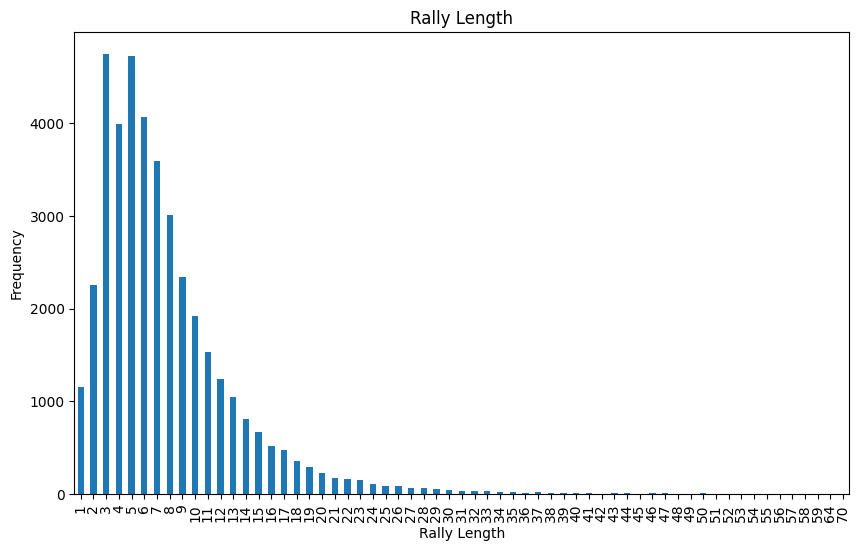

In [ ]:
import pandas as pd
import pandasql as ps
import matplotlib.pyplot as plt


rally_csv = pd.read_csv('../dataset/kaggle-data/rally.csv')
player_csv = pd.read_csv('../dataset/kaggle-data/player.csv')
team_csv = pd.read_csv('../dataset/kaggle-data/team.csv')
game_csv = pd.read_csv('../dataset/kaggle-data/game.csv')
shot_csv = pd.read_csv('../dataset/kaggle-data/shot.csv')

serve_team_wins = (rally_csv['w_team_id'] == rally_csv['srv_team_id']).sum()
total_rallies = len(rally_csv)
percentage = (serve_team_wins / total_rallies) * 100

print(f"Percentage of points won by serving team: {percentage:.2f}%")
print(f"Percentage of points won by returning team: {(100-percentage):.2f}%")
print(f"Total rallies: {total_rallies}")

rally_len_counts = rally_csv['rally_len'].value_counts().sort_index()
rally_len_counts = rally_len_counts[rally_len_counts.index > 0]
rally_len_counts.index = rally_len_counts.index.astype(int)

print("Mean rally length:", rally_csv['rally_len'].mean().round(2))
print("Median rally length:", rally_csv['rally_len'].median())

plt.figure(figsize=(8, 5))
rally_len_counts.plot(kind='bar')
plt.title('Rally Length')
plt.xlabel('Rally Length')
plt.ylabel('Frequency')

plt.show()

# Basic Analysis

We've established that the serving team *is* facing a disadvantage in the point. Based on over 40,000 rallies, the serving team won *42.46%* of their points. We'll use this in the accompanying simulation.

Let's try to uncover more information about how the serving team fares on their initial serve.

/var/folders/0c/4kjp223j3953r8crldck84b40000gn/T/ipykernel_83483/3877797510.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rally_sorted.groupby('game_id')


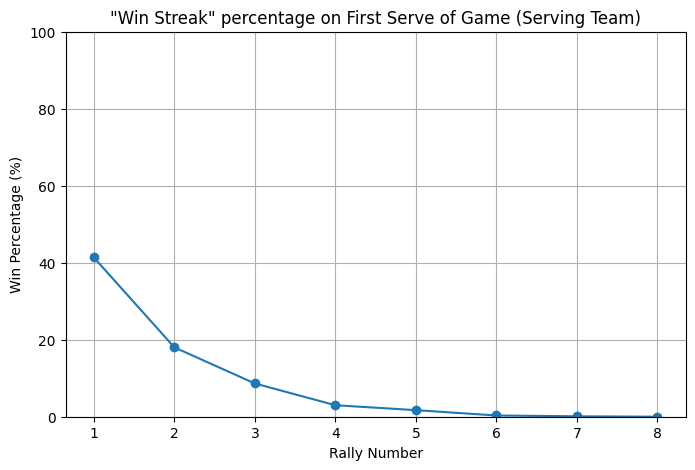

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

n = 8
rally_sorted = rally_csv.sort_values(['game_id', 'rally_nbr'])
first_srv_team = rally_sorted.groupby('game_id')['srv_team_id'].first()
rally_sorted['first_srv_team_id'] = rally_sorted['game_id'].map(first_srv_team)

def get_initial_service_sequence(df):
    rallies = []
    for _, row in df.iterrows():
        if row['srv_team_id'] == row['first_srv_team_id']:
            rallies.append(row)
        else:
            break
    return pd.DataFrame(rallies)

initial_service_rallies = (
    rally_sorted.groupby('game_id')
    .apply(get_initial_service_sequence)
    .reset_index(drop=True)
)

game_ids = rally_sorted['game_id'].unique()
win_matrix = np.zeros((len(game_ids), n)) * np.nan
game_id_to_idx = {gid: idx for idx, gid in enumerate(game_ids)}

for gid, group in initial_service_rallies.groupby('game_id'):
    for i in range(n):
        try:
            rally = group.iloc[i]
            win_matrix[game_id_to_idx[gid], i] = int(rally['w_team_id'] == rally['srv_team_id'])
        except IndexError:
            win_matrix[game_id_to_idx[gid], i] = 0 

win_percentages = np.nanmean(win_matrix, axis=0) * 100

plt.figure(figsize=(8,5))
plt.plot(range(1, n+1), win_percentages, marker='o')
plt.title('"Win Streak" percentage on First Serve of Game (Serving Team)')
plt.xlabel('Rally Number')
plt.ylabel('Win Percentage (%)')
plt.xticks(range(1, n+1))
plt.ylim(0, 100)
plt.grid(True)
plt.show()



Success rate by third shot type:
shot_type
Drive    41.741156
Lob      40.747029
Drop     40.217229
Name: serving_team_won, dtype: float64


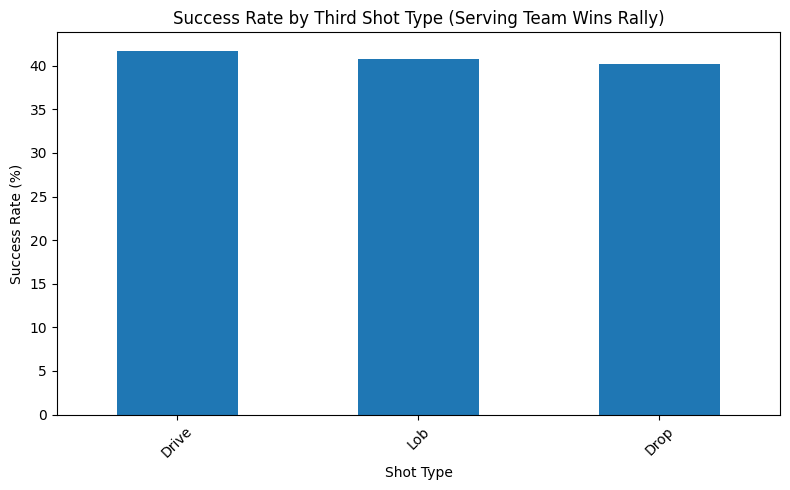

In [ ]:
third_shots = shot_csv[shot_csv['shot_nbr'] == 3].copy()

shot_type_map = {'tsDrv': 'Drive', 'tsLob': 'Lob', 'tsDrp': 'Drop'}
third_shots['shot_type'] = third_shots['shot_type'].replace(shot_type_map)

third_shots = third_shots.merge(
    rally_csv[['rally_id', 'w_team_id', 'srv_team_id']],
    on='rally_id', how='left'
)

third_shots['serving_team_won'] = third_shots['w_team_id'] == third_shots['srv_team_id']

success_by_type = third_shots.groupby('shot_type')['serving_team_won'].mean() * 100
print("\nSuccess rate by third shot type:")
print(success_by_type.sort_values(ascending=False))

plt.figure(figsize=(8,5))
success_by_type.sort_values(ascending=False).plot(kind='bar')
plt.title('Success Rate by Third Shot Type (Serving Team Wins Rally)')
plt.xlabel('Shot Type')
plt.ylabel('Success Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Next Steps

This dataset is quite comprehensive and this "analysis" barely scratches the surface on what we can learn. Some immediate next steps would be to break the data down further by DUPR rating to get more tailored insights by skill level. Additionally, each shot in the dataset includes the coordinates at which it landed. With this data, we can investigate the efficacy of serves (deep serve vs shallow serve), dink placement, and much more.